# Investigation of batch effects between two atlas studies

**Keywords**

<ins>*Transcripts Per Million (TPM)*</ins>: The sum of ALL normalized transcript expression values is divided by 1,000,000, to create a scaling factor. Each transcript's normalized expression is divided by the scaling factor, which results in the TPM value.

<ins>*Fragments Per Kilobase of transcript per Million mapped reads (FPKM)*</ins>: Simple expression level normalization method. The FPKM normalizes read count based on gene length and the total number of mapped reads.

<ins>*Counts Per Million mapped reads (CPM)*</ins>: The number of raw reads mapped to a transcript, scaled by the number of sequencing reads in your sample, multiplied by a million. It normalizes RNA-seq data for sequencing depth but not gene length

# 1. Pre-requisites
## 1.1 Import Packages

In [1]:
import gzip
import json
import warnings

import pronto
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display
import bz2

In [ ]:
#these need to be installed first
! sudo apt install tree
! sudo apt install jq
! pip install pronto

## 1.2 Download bulk dataset

Data used for the bulk RNA-seq expression is the [GTEx Consortium](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-5214/Results) experiment which sampled data from 53 human tissue samples from Expression Atlas. The entire database from Expression Atlas was accessed from a google cloud bucket which contains the data processed by the Expression Atlas. Below I create directories 'metadata', containing the experiments metadata to (JSON format), and 'aggregated data', containing two files for each experiment (TPM counts and FKPM counts).

In [25]:
! mkdir -p 'aggregated_data' 'metadata'
! gsutil -q -m rsync -r 'gs://ot-team/tskir/rel_38_2023-03-31/aggregated_data' 'aggregated_data'
! gsutil -q -m rsync -r 'gs://ot-team/tskir/rel_38_2023-03-31/metadata' 'metadata'

Below is a list of the experiments contained within the Expression Atlas data. Each experiment is listed as an individual directory.

In [2]:
!ls metadata

E-CURD-15      E-GEOD-43721  E-GEOD-94457  E-MTAB-3724	E-MTAB-5117
E-CURD-23      E-GEOD-43727  E-GEOD-95399  E-MTAB-3725	E-MTAB-513
E-CURD-25      E-GEOD-44366  E-GEOD-95678  E-MTAB-3726	E-MTAB-5200
E-CURD-26      E-GEOD-46817  E-GEOD-97960  E-MTAB-3727	E-MTAB-5214
E-CURD-27      E-GEOD-46858  E-GEOD-98097  E-MTAB-3819	E-MTAB-5423
E-CURD-30      E-GEOD-47948  E-GEOD-98379  E-MTAB-3826	E-MTAB-552
E-CURD-31      E-GEOD-49906  E-GEOD-98817  E-MTAB-3827	E-MTAB-5782
E-CURD-33      E-GEOD-50191  E-GEOD-99122  E-MTAB-3838	E-MTAB-5895
E-CURD-34      E-GEOD-50777  E-GEUV-1	   E-MTAB-3839	E-MTAB-5915
E-CURD-35      E-GEOD-51662  E-MTAB-10582  E-MTAB-3871	E-MTAB-5956
E-CURD-39      E-GEOD-52564  E-MTAB-10583  E-MTAB-3983	E-MTAB-599
E-CURD-47      E-GEOD-52806  E-MTAB-10847  E-MTAB-4021	E-MTAB-6422
E-ENAD-1       E-GEOD-53960  E-MTAB-11005  E-MTAB-4034	E-MTAB-6592
E-ENAD-11      E-GEOD-54272  E-MTAB-11442  E-MTAB-4045	E-MTAB-6769
E-ENAD-2       E-GEOD-55482  E-MTAB-11622  E-MTAB-4101	E-MTAB-6782


In [33]:
! tree 'metadata' | head -10

metadata
├── E-CURD-15
│   └── E-CURD-15.metadata.json
├── E-CURD-23
│   └── E-CURD-23.metadata.json
├── E-CURD-25
│   └── E-CURD-25.metadata.json
├── E-CURD-26
│   └── E-CURD-26.metadata.json
├── E-CURD-27


In [35]:
! tree 'aggregated_data' | head -19

aggregated_data
├── E-CURD-15
│   ├── E-CURD-15-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-15-expression-data-tpms.jsonl.bz2
├── E-CURD-23
│   ├── E-CURD-23-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-23-expression-data-tpms.jsonl.bz2
├── E-CURD-25
│   ├── E-CURD-25-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-25-expression-data-tpms.jsonl.bz2
├── E-CURD-26
│   ├── E-CURD-26-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-26-expression-data-tpms.jsonl.bz2
├── E-CURD-27
│   ├── E-CURD-27-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-27-expression-data-tpms.jsonl.bz2
├── E-CURD-30
│   ├── E-CURD-30-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-30-expression-data-tpms.jsonl.bz2


## 1.3 Read in Tabular Sapiens expression data

In [20]:
tabula_sapiens = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')
tabula_sapiens

ENSG00000227232  ENSG00000268903  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000241860  ENSG00000279457  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000228463  ENSG00000237094  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000225972  ENSG00000225630  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                              0.000000         0.101790   
               endothelial cell                    0.000000         0.000000   
               mast cell                           0.027070         1.606588   
               myeloid cell                        0.000000         0.000000   
               pancreatic acinar cell              0.000000         0.000000   
...                                                     ...              ...   
UBERON:0018707 plasma cell                         0.000000         0.000000   
               plasmacytoid dendritic cell         0.000000         0.000000   
               smooth muscle cell                  2.210239         0.000000   
               t cell                    

# 2. GTEx experiment
## 2.1 Access GTEx experiment

I want to use the GTEx dataset since it is large and internally consistent like the Tabula Sapiens Atlas meaning it does not require batch correction within it. Inside the Expression Atlas data, GTEx is found under the **E-MTAB-5214** experiment. But first, I need to define functions which can help extract the information needed. The cell below describes bash functions to extract the tissue names from the experiments and process the tissues into groups.

In [3]:
%%bash
cat <<'EOF' >bash_functions.sh
#!/bin/bash
extract_tissues () {
  # Not extracting cell types for now
  jq --raw-output '. as $experiment | .experimentalDesigns | .[] | $experiment.experimentId + "|" + .assayGroupId + "|" + .organismPart + "|" + .organismPartOntURI' <"$1" \
  | sort -u
}
process_tissues () {
  cut -d'|' -f3,4 \
  | sort \
  | uniq -c \
  | sort -k1,1rn \
  | sed -e 's/^ *//' -e 's/ /|/' \
  | tr '|' '\t'
}
export -f extract_tissues process_tissues
EOF

In [40]:
%%bash
. bash_functions.sh
extract_tissues metadata/E-MTAB-5214/E-MTAB-5214.metadata.json | process_tissues >'tissues_gtex.tsv'

## 2.2 List of tissues

In [2]:
#read in table of tissue assays
GTEx = pd.read_table('tissues_gtex.tsv', names=('count', 'organismPart', 'organismPartOntURI'))
with pd.option_context('display.max_rows', 500):
    display.display(GTEx)

,count,organismPart,organismPartOntURI
0,1,Brodmann (1909) area 24,http://purl.obolibrary.org/obo/UBERON_0006101
1,1,Brodmann (1909) area 9,http://purl.obolibrary.org/obo/UBERON_0013540
2,1,C1 segment of cervical spinal cord,http://purl.obolibrary.org/obo/UBERON_0006469
3,1,EBV-transformed lymphocyte,http://purl.obolibrary.org/obo/CL_0000542
4,1,adrenal gland,http://purl.obolibrary.org/obo/UBERON_0002369
5,1,amygdala,http://purl.obolibrary.org/obo/UBERON_0001876
6,1,aorta,http://purl.obolibrary.org/obo/UBERON_0000947
7,1,atrium auricular region,http://purl.obolibrary.org/obo/UBERON_0006618
8,1,blood,http://purl.obolibrary.org/obo/UBERON_0000178
9,1,breast,http://purl.obolibrary.org/obo/UBERON_0000310


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#change index to assay column
GTEx = GTEx.reset_index()
GTEx = GTEx.rename(columns = {'index': 'assay'})

#rename assays to reflect the ones in the expression data JSON file
for i in range(len(GTEx)):
    n = i + 1
    GTEx.assay[i] = f'g{n}'

#sort dataframe by assay_id string and reset the index so it is in the correct order, dropping the previous index
GTEx = GTEx.sort_values('assay').reset_index()
GTEx = GTEx.drop(columns = 'index')

GTEx

/tmp/ipykernel_1438/4229445611.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GTEx.assay[i] = f'g{n}'


,assay,count,organismPart,organismPartOntURI
0,g1,1,Brodmann (1909) area 24,http://purl.obolibrary.org/obo/UBERON_0006101
1,g10,1,breast,http://purl.obolibrary.org/obo/UBERON_0000310
2,g11,1,caudate nucleus,http://purl.obolibrary.org/obo/UBERON_0001873
3,g12,1,cerebellar hemisphere,http://purl.obolibrary.org/obo/UBERON_0002245
4,g13,1,cerebellum,http://purl.obolibrary.org/obo/UBERON_0002037
5,g14,1,cerebral cortex,http://purl.obolibrary.org/obo/UBERON_0000956
6,g15,1,coronary artery,http://purl.obolibrary.org/obo/UBERON_0001621
7,g16,1,cortex of kidney,http://purl.obolibrary.org/obo/UBERON_0001225
8,g17,1,ectocervix,http://purl.obolibrary.org/obo/UBERON_0012249
9,g18,1,endocervix,http://purl.obolibrary.org/obo/UBERON_0000458


There are 53 tissues with their corresponding UBERON IDs and there is only one aggregated assay per tissue.

## 2.3 Process expression data into pandas dataframe

In order to be able to 'compare' between bulk and single-cell RNA-seq data I will be using the TPM values for the expression data.

In [4]:
# Initialise Spark session
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '60g')
    .set('spark.executor.memory', '60g')
    .set('spark.driver.maxResultSize', '0')
    .set('spark.debug.maxToStringFields', '2000')
    .set('spark.sql.execution.arrow.maxRecordsPerBatch', '500000')
)
spark = SparkSession.builder.config(conf=sparkConf).master('local[*]').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/26 08:49:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#read in aggregated expression dataframe
GTEx_TPM = spark.read.json('aggregated_data/E-MTAB-5214/E-MTAB-5214-expression-data-tpms.jsonl.bz2')

In [6]:
#visualise data and schema
GTEx_TPM.printSchema()
GTEx_TPM.show()

root
 |-- expression: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- assayGroupId: string (nullable = true)
 |    |    |-- max: double (nullable = true)
 |    |    |-- min: double (nullable = true)
 |    |    |-- q1: double (nullable = true)
 |    |    |-- q2: double (nullable = true)
 |    |    |-- q3: double (nullable = true)
 |-- geneProductId: string (nullable = true)
 |-- unit: string (nullable = true)

+--------------------+---------------+----+
|          expression|  geneProductId|unit|
+--------------------+---------------+----+
|[{g1, 17.0, 0.0, ...|ENSG00000000003|tpms|
|[{g1, 0.6, 0.0, 0...|ENSG00000000005|tpms|
|[{g1, 87.0, 0.0, ...|ENSG00000000419|tpms|
|[{g1, 3.0, 0.0, 2...|ENSG00000000457|tpms|
|[{g1, 1.0, 0.0, 0...|ENSG00000000460|tpms|
|[{g1, 54.0, 0.0, ...|ENSG00000000938|tpms|
|[{g1, 30.0, 0.0, ...|ENSG00000000971|tpms|
|[{g1, 24.0, 0.0, ...|ENSG00000001036|tpms|
|[{g1, 23.0, 0.0, ...|ENSG00000001084|tpms|
|[{g1, 28.0, 0.0, ..

We only want to use the median expression (q2) values to compare them to the single-cell RNA-seq expressions.

In [7]:
#extract columns we are interested in
GTEx_counts = (
    GTEx_TPM
    .withColumn('expression_expl', explode('expression'))
    .select('geneProductId', 'expression_expl.assayGroupId', 'expression_expl.q2'))

GTEx_counts.show()

+---------------+------------+----+
|  geneProductId|assayGroupId|  q2|
+---------------+------------+----+
|ENSG00000000003|          g1| 6.0|
|ENSG00000000003|         g10|36.0|
|ENSG00000000003|         g11| 7.0|
|ENSG00000000003|         g12| 2.0|
|ENSG00000000003|         g13| 3.0|
|ENSG00000000003|         g14| 5.0|
|ENSG00000000003|         g15|11.0|
|ENSG00000000003|         g16|15.0|
|ENSG00000000003|         g17|39.0|
|ENSG00000000003|         g18|47.0|
|ENSG00000000003|         g19|10.0|
|ENSG00000000003|          g2| 5.0|
|ENSG00000000003|         g20|37.0|
|ENSG00000000003|         g21| 8.0|
|ENSG00000000003|         g22|30.0|
|ENSG00000000003|         g23|28.0|
|ENSG00000000003|         g24| 2.0|
|ENSG00000000003|         g25| 6.0|
|ENSG00000000003|         g26| 9.0|
|ENSG00000000003|         g27|24.0|
+---------------+------------+----+
only showing top 20 rows



In [8]:
#list of unique assay group IDs
assay_groups = sorted(
    [a.assayGroupId for a in GTEx_counts.select('assayGroupId').distinct().collect()])

In [9]:
#aggregate values into single expression map per gene
GTEx_counts = (
    GTEx_counts
    .groupby('geneProductId')
    .agg(
        f.map_from_entries(
            f.collect_list(
                f.struct('assayGroupId', 'q2')
            )
        ).alias('expression_map')))

GTEx_counts.show()

+---------------+--------------------+
|  geneProductId|      expression_map|
+---------------+--------------------+
|ENSG00000001561|{g1 -> 14.0, g10 ...|
|ENSG00000002822|{g1 -> 4.0, g10 -...|
|ENSG00000004142|{g1 -> 76.0, g10 ...|
|ENSG00000004766|{g1 -> 6.0, g10 -...|
|ENSG00000004809|{g1 -> 0.0, g10 -...|
|ENSG00000004948|{g1 -> 0.1, g10 -...|
|ENSG00000004975|{g1 -> 8.0, g10 -...|
|ENSG00000005073|{g1 -> 0.0, g10 -...|
|ENSG00000005175|{g1 -> 6.0, g10 -...|
|ENSG00000005187|{g1 -> 0.1, g10 -...|
|ENSG00000005486|{g1 -> 187.0, g10...|
|ENSG00000005884|{g1 -> 6.0, g10 -...|
|ENSG00000006015|{g1 -> 30.0, g10 ...|
|ENSG00000006071|{g1 -> 16.0, g10 ...|
|ENSG00000006194|{g10 -> 14.0, g11...|
|ENSG00000006283|{g1 -> 5.0, g10 -...|
|ENSG00000006638|{g1 -> 1.0, g10 -...|
|ENSG00000007062|{g1 -> 2.0, g10 -...|
|ENSG00000007216|{g1 -> 0.0, g10 -...|
|ENSG00000007264|{g1 -> 31.0, g10 ...|
+---------------+--------------------+
only showing top 20 rows



In [10]:
#convert single-mapped expression values into different columns
expression_cols = [f.col('expression_map').getItem(x).alias(str(x)) 
              for x in assay_groups]

#extract dataframe with assay as columns, genes as rows and values as TPMs
GTEx_expression = GTEx_counts.select('geneProductId', *expression_cols).toPandas()
GTEx_expression.set_index('geneProductId', inplace = True)

23/09/26 08:49:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
GTEx_expression

,g1,g10,g11,g12,g13,g14,g15,g16,g17,g18,...,g49,g5,g50,g51,g52,g53,g6,g7,g8,g9
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,14.0,19.0,12.0,17.0,16.0,13.0,39.0,10.0,6.0,13.0,...,4.0,10.0,14.0,13.0,6.0,5.0,11.0,34.0,12.0,2.0
ENSG00000002822,4.0,8.0,5.0,8.0,7.0,6.0,6.0,4.0,11.0,10.0,...,9.0,4.0,5.0,7.0,10.0,9.0,3.0,7.0,4.0,6.0
ENSG00000004142,76.0,110.0,55.0,102.0,107.0,96.0,118.0,134.0,114.0,114.0,...,172.0,227.0,94.0,102.0,117.0,109.0,51.0,118.0,89.0,36.0
ENSG00000004766,6.0,8.0,4.0,15.0,14.0,8.0,8.0,4.0,9.0,9.0,...,9.0,7.0,7.0,7.0,10.0,9.0,3.0,8.0,3.0,1.0
ENSG00000004809,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,...,0.0,0.1,0.0,0.1,0.6,0.0,0.0,0.1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000281906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000281909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.4 Filter out genes with zero expression across all assays

In [12]:
#use filter to eliminate genes that have zero expression across all tissue assays
non_zero = ~np.all(GTEx_expression == 0, axis = 1)
GTEx_expression = GTEx_expression[non_zero]

GTEx_expression

,g1,g10,g11,g12,g13,g14,g15,g16,g17,g18,...,g49,g5,g50,g51,g52,g53,g6,g7,g8,g9
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,14.0,19.0,12.0,17.0,16.0,13.0,39.0,10.0,6.0,13.0,...,4.0,10.0,14.0,13.0,6.0,5.0,11.0,34.0,12.0,2.0
ENSG00000002822,4.0,8.0,5.0,8.0,7.0,6.0,6.0,4.0,11.0,10.0,...,9.0,4.0,5.0,7.0,10.0,9.0,3.0,7.0,4.0,6.0
ENSG00000004142,76.0,110.0,55.0,102.0,107.0,96.0,118.0,134.0,114.0,114.0,...,172.0,227.0,94.0,102.0,117.0,109.0,51.0,118.0,89.0,36.0
ENSG00000004766,6.0,8.0,4.0,15.0,14.0,8.0,8.0,4.0,9.0,9.0,...,9.0,7.0,7.0,7.0,10.0,9.0,3.0,8.0,3.0,1.0
ENSG00000004809,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,...,0.0,0.1,0.0,0.1,0.6,0.0,0.0,0.1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281676,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,2.0,...,1.0,0.8,1.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0
ENSG00000281741,0.6,0.5,0.4,0.6,0.6,0.6,0.6,0.4,0.7,0.6,...,0.3,0.4,0.3,0.6,0.3,0.4,0.4,0.7,0.1,0.8
ENSG00000281809,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.2,0.0,1.0,0.5,0.0,0.0,0.1,0.0,0.0,0.0


## 2.5 Set tissue name as column index

In [33]:
%%bash
. bash_functions.sh
extract_tissues metadata/E-MTAB-5214/E-MTAB-5214.metadata.json | tr '|' '\t' | cut -f2,3 > gtex_map.tsv

In [13]:
#create a dictionary for the tissue names from the gtex_map file and rename the columns in GTEx tissue TPM
GTEx_col_map = dict([line.split('\t') for line in open('gtex_map.tsv').read().splitlines()])
GTEx_tissue_TPM = (GTEx_expression
                   .rename(columns = GTEx_col_map))

GTEx_tissue_TPM

,Brodmann (1909) area 24,breast,caudate nucleus,cerebellar hemisphere,cerebellum,cerebral cortex,coronary artery,cortex of kidney,ectocervix,endocervix,...,transformed skin fibroblast,adrenal gland,transverse colon,urinary bladder,uterus,vagina,amygdala,aorta,atrium auricular region,blood
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,14.0,19.0,12.0,17.0,16.0,13.0,39.0,10.0,6.0,13.0,...,4.0,10.0,14.0,13.0,6.0,5.0,11.0,34.0,12.0,2.0
ENSG00000002822,4.0,8.0,5.0,8.0,7.0,6.0,6.0,4.0,11.0,10.0,...,9.0,4.0,5.0,7.0,10.0,9.0,3.0,7.0,4.0,6.0
ENSG00000004142,76.0,110.0,55.0,102.0,107.0,96.0,118.0,134.0,114.0,114.0,...,172.0,227.0,94.0,102.0,117.0,109.0,51.0,118.0,89.0,36.0
ENSG00000004766,6.0,8.0,4.0,15.0,14.0,8.0,8.0,4.0,9.0,9.0,...,9.0,7.0,7.0,7.0,10.0,9.0,3.0,8.0,3.0,1.0
ENSG00000004809,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,...,0.0,0.1,0.0,0.1,0.6,0.0,0.0,0.1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281676,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,2.0,...,1.0,0.8,1.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0
ENSG00000281741,0.6,0.5,0.4,0.6,0.6,0.6,0.6,0.4,0.7,0.6,...,0.3,0.4,0.3,0.6,0.3,0.4,0.4,0.7,0.1,0.8
ENSG00000281809,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.2,0.0,1.0,0.5,0.0,0.0,0.1,0.0,0.0,0.0


In [14]:
#transpose matrix so it resembles the Tabula Sapiens one
transposed_GTEx_tissue_TPM = GTEx_tissue_TPM.T

transposed_GTEx_tissue_TPM

geneProductId,ENSG00000001561,ENSG00000002822,ENSG00000004142,ENSG00000004766,ENSG00000004809,ENSG00000004948,ENSG00000004975,ENSG00000005073,ENSG00000005175,ENSG00000005187,...,ENSG00000281548,ENSG00000281549,ENSG00000281566,ENSG00000281571,ENSG00000281655,ENSG00000281676,ENSG00000281741,ENSG00000281809,ENSG00000281909,ENSG00000281912
Brodmann (1909) area 24,14.0,4.0,76.0,6.0,0.0,0.1,8.0,0.0,6.0,0.1,...,0.4,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
breast,19.0,8.0,110.0,8.0,0.1,0.1,24.0,0.7,11.0,2.0,...,1.0,0.0,0.0,2.0,0.9,1.0,0.5,0.0,0.0,2.0
caudate nucleus,12.0,5.0,55.0,4.0,0.0,0.0,8.0,0.0,5.0,0.1,...,0.4,0.0,0.0,1.0,0.0,0.0,0.4,0.0,0.0,1.0
cerebellar hemisphere,17.0,8.0,102.0,15.0,0.0,0.0,31.0,0.0,16.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
cerebellum,16.0,7.0,107.0,14.0,0.0,0.0,37.0,0.0,14.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
cerebral cortex,13.0,6.0,96.0,8.0,0.0,0.0,15.0,0.0,6.0,0.1,...,0.5,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
coronary artery,39.0,6.0,118.0,8.0,0.1,0.1,22.0,0.0,11.0,3.0,...,0.8,0.0,0.0,3.0,0.0,0.0,0.6,0.0,0.0,1.0
cortex of kidney,10.0,4.0,134.0,4.0,0.1,0.9,13.0,3.0,5.0,7.0,...,0.5,0.0,0.0,3.0,0.1,0.0,0.4,0.0,0.0,2.0
ectocervix,6.0,11.0,114.0,9.0,0.0,0.0,50.0,57.0,15.0,15.0,...,1.0,0.0,0.0,3.0,0.0,0.7,0.7,0.0,0.0,3.0
endocervix,13.0,10.0,114.0,9.0,0.1,0.1,50.0,102.0,16.0,10.0,...,1.0,0.0,0.0,4.0,0.0,2.0,0.6,0.0,0.0,3.0


In [14]:
#save dataframe as compressed pickle
transposed_GTEx_tissue_TPM.to_pickle('median_GTEx_tissue_id_TPM.pkl', compression = 'gzip')

# 3. Comparison between Tabula Sapiens single-cell and GTEx bulk
## 3.1 Convert tissue names to UBERON IDs for comparison

I'm interested in the tissues which are shared across both datasets so for accurate comparison across tissues I shall use the UBERON IDs.

In [15]:
#create list of uberon ids from the GTEx dataframe which matches the indexing of the dataframe columns
uberonid = []
for i in range(len(GTEx.organismPartOntURI)):
    uberon_num = GTEx.organismPartOntURI[i][-14:].replace('_', ':')
    uberonid.append(uberon_num)

In [16]:
#set the dataframe column axis as the uberon ids and transpose so matches Tabula Sapiens format
uberon_id_GTEx_expression = GTEx_expression.set_axis(uberonid, axis = 1)
uberon_id_GTEx_expression = uberon_id_GTEx_expression.T
uberon_id_GTEx_expression

geneProductId,ENSG00000001561,ENSG00000002822,ENSG00000004142,ENSG00000004766,ENSG00000004809,ENSG00000004948,ENSG00000004975,ENSG00000005073,ENSG00000005175,ENSG00000005187,...,ENSG00000281548,ENSG00000281549,ENSG00000281566,ENSG00000281571,ENSG00000281655,ENSG00000281676,ENSG00000281741,ENSG00000281809,ENSG00000281909,ENSG00000281912
UBERON:0006101,14.0,4.0,76.0,6.0,0.0,0.1,8.0,0.0,6.0,0.1,...,0.4,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
UBERON:0000310,19.0,8.0,110.0,8.0,0.1,0.1,24.0,0.7,11.0,2.0,...,1.0,0.0,0.0,2.0,0.9,1.0,0.5,0.0,0.0,2.0
UBERON:0001873,12.0,5.0,55.0,4.0,0.0,0.0,8.0,0.0,5.0,0.1,...,0.4,0.0,0.0,1.0,0.0,0.0,0.4,0.0,0.0,1.0
UBERON:0002245,17.0,8.0,102.0,15.0,0.0,0.0,31.0,0.0,16.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
UBERON:0002037,16.0,7.0,107.0,14.0,0.0,0.0,37.0,0.0,14.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
UBERON:0000956,13.0,6.0,96.0,8.0,0.0,0.0,15.0,0.0,6.0,0.1,...,0.5,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
UBERON:0001621,39.0,6.0,118.0,8.0,0.1,0.1,22.0,0.0,11.0,3.0,...,0.8,0.0,0.0,3.0,0.0,0.0,0.6,0.0,0.0,1.0
UBERON:0001225,10.0,4.0,134.0,4.0,0.1,0.9,13.0,3.0,5.0,7.0,...,0.5,0.0,0.0,3.0,0.1,0.0,0.4,0.0,0.0,2.0
UBERON:0012249,6.0,11.0,114.0,9.0,0.0,0.0,50.0,57.0,15.0,15.0,...,1.0,0.0,0.0,3.0,0.0,0.7,0.7,0.0,0.0,3.0
UBERON:0000458,13.0,10.0,114.0,9.0,0.1,0.1,50.0,102.0,16.0,10.0,...,1.0,0.0,0.0,4.0,0.0,2.0,0.6,0.0,0.0,3.0


## 3.2 Drop cell ontology (CL) rows

The rows with cell ontology terms, beginning with `CL`, will be dropped since these are not present in the Tabula Sapiens dataset.

In [17]:
uberon_id_GTEx_expression = uberon_id_GTEx_expression.drop(['obo/CL:0000057', 'obo/CL:0000542'])
uberon_id_GTEx_expression

geneProductId,ENSG00000001561,ENSG00000002822,ENSG00000004142,ENSG00000004766,ENSG00000004809,ENSG00000004948,ENSG00000004975,ENSG00000005073,ENSG00000005175,ENSG00000005187,...,ENSG00000281548,ENSG00000281549,ENSG00000281566,ENSG00000281571,ENSG00000281655,ENSG00000281676,ENSG00000281741,ENSG00000281809,ENSG00000281909,ENSG00000281912
UBERON:0006101,14.0,4.0,76.0,6.0,0.0,0.1,8.0,0.0,6.0,0.1,...,0.4,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
UBERON:0000310,19.0,8.0,110.0,8.0,0.1,0.1,24.0,0.7,11.0,2.0,...,1.0,0.0,0.0,2.0,0.9,1.0,0.5,0.0,0.0,2.0
UBERON:0001873,12.0,5.0,55.0,4.0,0.0,0.0,8.0,0.0,5.0,0.1,...,0.4,0.0,0.0,1.0,0.0,0.0,0.4,0.0,0.0,1.0
UBERON:0002245,17.0,8.0,102.0,15.0,0.0,0.0,31.0,0.0,16.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
UBERON:0002037,16.0,7.0,107.0,14.0,0.0,0.0,37.0,0.0,14.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
UBERON:0000956,13.0,6.0,96.0,8.0,0.0,0.0,15.0,0.0,6.0,0.1,...,0.5,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
UBERON:0001621,39.0,6.0,118.0,8.0,0.1,0.1,22.0,0.0,11.0,3.0,...,0.8,0.0,0.0,3.0,0.0,0.0,0.6,0.0,0.0,1.0
UBERON:0001225,10.0,4.0,134.0,4.0,0.1,0.9,13.0,3.0,5.0,7.0,...,0.5,0.0,0.0,3.0,0.1,0.0,0.4,0.0,0.0,2.0
UBERON:0012249,6.0,11.0,114.0,9.0,0.0,0.0,50.0,57.0,15.0,15.0,...,1.0,0.0,0.0,3.0,0.0,0.7,0.7,0.0,0.0,3.0
UBERON:0000458,13.0,10.0,114.0,9.0,0.1,0.1,50.0,102.0,16.0,10.0,...,1.0,0.0,0.0,4.0,0.0,2.0,0.6,0.0,0.0,3.0


## 3.3 Identify UBERON IDs conserved across both datasets

In [18]:
#GTEx tissue UBERON IDs
GTEX_uberon_ids = uberon_id_GTEx_expression.index

In [21]:
#UBERON IDs from Tabula Sapiens dataframe
###reset index to eliminate multi-index so can access uberon_id
##access list of unique UBERON IDs as they are repeated
tabula_uberon_ids = tabula_sapiens.reset_index().uberon_id.unique()

In [22]:
#find which UBERON IDs are shared across both datasets
shared_uberon_ids = set(GTEX_uberon_ids) & set(tabula_uberon_ids)
shared_uberon_ids

{'UBERON:0000178',
 'UBERON:0000947',
 'UBERON:0000995',
 'UBERON:0001621',
 'UBERON:0002048',
 'UBERON:0002106',
 'UBERON:0002107',
 'UBERON:0002190',
 'UBERON:0002367'}

Here, I see that there are nine tissues across GTEx and Tabula Sapiens that share the exact same UBERON ID so I will use these to compare the two datasets.

## 3.4 Reformat datasets to retain only shared UBERON ID data

In [23]:
#filter GTEx by shared UBERON ID rows
shared_uberon_id_GTEx_expression = uberon_id_GTEx_expression.filter(shared_uberon_ids, axis = 0)
shared_uberon_id_GTEx_expression

geneProductId,ENSG00000001561,ENSG00000002822,ENSG00000004142,ENSG00000004766,ENSG00000004809,ENSG00000004948,ENSG00000004975,ENSG00000005073,ENSG00000005175,ENSG00000005187,...,ENSG00000281548,ENSG00000281549,ENSG00000281566,ENSG00000281571,ENSG00000281655,ENSG00000281676,ENSG00000281741,ENSG00000281809,ENSG00000281909,ENSG00000281912
UBERON:0001621,39.0,6.0,118.0,8.0,0.1,0.1,22.0,0.0,11.0,3.0,...,0.8,0.0,0.0,3.0,0.0,0.0,0.6,0.0,0.0,1.0
UBERON:0002107,5.0,3.0,159.0,2.0,0.0,0.0,6.0,0.0,4.0,8.0,...,0.3,0.0,0.0,2.0,3.0,0.0,0.3,0.0,0.0,1.0
UBERON:0002048,29.0,8.0,100.0,8.0,0.4,0.1,23.0,0.0,10.0,3.0,...,1.0,0.0,0.0,3.0,0.0,2.0,0.5,1.0,0.0,1.0
UBERON:0002367,12.0,8.0,117.0,7.0,0.1,0.0,37.0,24.0,11.0,6.0,...,1.0,0.0,0.0,3.0,0.2,2.0,0.7,0.5,0.1,3.0
UBERON:0002106,15.0,13.0,104.0,9.0,0.5,0.0,23.0,0.0,13.0,1.0,...,1.0,0.0,0.0,7.0,0.0,3.0,1.0,0.0,0.0,2.0
UBERON:0002190,23.0,8.0,113.0,8.0,0.2,0.1,22.0,6.0,11.0,0.5,...,1.0,0.0,0.0,2.0,0.3,2.0,0.3,0.0,0.0,1.0
UBERON:0000995,6.0,10.0,117.0,10.0,0.6,0.0,52.0,149.0,16.0,34.0,...,1.0,0.0,0.0,2.0,0.1,2.0,0.3,0.0,0.0,2.0
UBERON:0000947,34.0,7.0,118.0,8.0,0.1,0.1,26.0,0.1,12.0,0.9,...,0.8,0.0,0.0,3.0,0.0,0.0,0.7,0.0,0.0,1.0
UBERON:0000178,2.0,6.0,36.0,1.0,1.0,0.0,5.0,0.0,3.0,0.5,...,0.5,0.0,0.0,3.0,0.0,2.0,0.8,0.0,0.0,0.2


In [24]:
#filter Tabula Sapiens by shared UBERON IDs across the multi-index using level = 0 to specify the uberon_id index
shared_uberon_id_tabula_sapiens = tabula_sapiens[tabula_sapiens.index.isin(shared_uberon_ids, level = 0)]
shared_uberon_id_tabula_sapiens

ENSG00000227232  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                            0.0   
               cd141-positive myeloid dendritic cell               0.0   
               cd24 neutrophil                                     0.0   
               cd4-positive, alpha-beta memory t cell              0.0   
               cd4-positive, alpha-beta t cell                     0.0   
...                                                                ...   
UBERON:0002367 nkt cell                                            0.0   
               smooth muscle cell                                  0.0   
               sperm                                               0.0   
               stromal cell                                        0.0   
               t cell                                              0.0   

                                                       ENSG00000268903  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                            0.0   
               cd141-positive myeloid dendritic cell               0.0   
               cd24 neutrophil                                     0.0   
               cd4-positive, alpha-beta memory t cell              0.0   
               cd4-positive, alpha-beta t cell                     0.0   
...                                                                ...   
UBERON:0002367 nkt cell                                            0.0   
               smooth muscle cell                                  0.0   
               sperm                                               0.0   
               stromal cell                                        0.0   
               t cell                                              0.0   

                                                       ENSG00000241860  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                            0.0   
               cd141-positive myeloid dendritic cell               0.0   
               cd24 neutrophil                                     0.0   
               cd4-positive, alpha-beta memory t cell              0.0   
               cd4-positive, alpha-beta t cell                     0.0   
...                                                                ...   
UBERON:0002367 nkt cell                                            0.0   
               smooth muscle cell                                  0.0   
               sperm                                               0.0   
               stromal cell                                        0.0   
               t cell                                              0.0   

                                                       ENSG00000279457  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                            0.0   
               cd141-positive myeloid dendritic cell               0.0   
               cd24 neutrophil                                     0.0   
               cd4-positive, alpha-beta memory t cell              0.0   
               cd4-positive, alpha-beta t cell                     0.0   
...                                                                ...   
UBERON:0002367 nkt cell                                            0.0   
               smooth muscle cell                                  0.0   
               sperm                                               0.0   
               stromal cell                                        0.0   
               t cell                                              0.0   

                                                       ENSG00000228463  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                

## 3.5 Merge shared UBERON ID dataframes

In [25]:
#eliminate cell_types from Tabula Sapiens to allow merging of dataframes on UBERON ID
ts = shared_uberon_id_tabula_sapiens.reset_index().drop(columns = 'cell_type').set_index('uberon_id')
ts

,ENSG00000227232,ENSG00000268903,ENSG00000241860,ENSG00000279457,ENSG00000228463,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
uberon_id,,,,,,,,,,,,,,,,,,,,,
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,23.122616,0.0,0.0,0.0,10.617577,0.689311,0.0,30.212013,0.0,0.761426
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,25.668995,0.0,0.0,0.0,13.845222,0.899192,0.0,36.836357,0.0,0.000000
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,6.858539,0.00000,...,24.904129,0.0,0.0,0.0,6.660645,0.000000,0.0,36.145561,0.0,15.926369
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,24.851427,0.0,0.0,0.0,11.422455,1.352069,0.0,40.610580,0.0,0.000000
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,23.102156,0.0,0.0,0.0,7.663464,1.667645,0.0,40.170292,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBERON:0002367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,50.350475,0.0,0.0,0.0,16.439199,0.000000,0.0,71.210800,0.0,0.000000
UBERON:0002367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,58.919147,0.0,0.0,0.0,15.376302,0.000000,0.0,79.589516,0.0,0.000000
UBERON:0002367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,15.944453,0.0,0.0,0.0,5.544242,0.000000,0.0,19.229773,0.0,0.000000


In [26]:
#concatenate dataframes and set levels as the dataset origin
merged_shared_uberon_id_datasets = pd.concat([shared_uberon_id_GTEx_expression, ts],
                                            keys = ['GTEx', 'Tabula_Sapiens'])
merged_shared_uberon_id_datasets

ENSG00000001561  ENSG00000002822  \
GTEx           UBERON:0001621        39.000000              6.0   
               UBERON:0002107         5.000000              3.0   
               UBERON:0002048        29.000000              8.0   
               UBERON:0002367        12.000000              8.0   
               UBERON:0002106        15.000000             13.0   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367         0.000000              0.0   
               UBERON:0002367         0.000000              0.0   
               UBERON:0002367         6.500235              0.0   
               UBERON:0002367         0.000000              0.0   
               UBERON:0002367         0.000000              0.0   

                               ENSG00000004142  ENSG00000004766  \
GTEx           UBERON:0001621            118.0              8.0   
               UBERON:0002107            159.0              2.0   
               UBERON:0002048            100.0              8.0   
               UBERON:0002367            117.0              7.0   
               UBERON:0002106            104.0              9.0   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   

                               ENSG00000004809  ENSG00000004948  \
GTEx           UBERON:0001621              0.1              0.1   
               UBERON:0002107              0.0              0.0   
               UBERON:0002048              0.4              0.1   
               UBERON:0002367              0.1              0.0   
               UBERON:0002106              0.5              0.0   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              0.0              NaN   
               UBERON:0002367              0.0              NaN   
               UBERON:0002367              0.0              NaN   
               UBERON:0002367              0.0              NaN   
               UBERON:0002367              0.0              NaN   

                               ENSG00000004975  ENSG00000005073  \
GTEx           UBERON:0001621             22.0              0.0   
               UBERON:0002107              6.0              0.0   
               UBERON:0002048             23.0              0.0   
               UBERON:0002367             37.0             24.0   
               UBERON:0002106             23.0              0.0   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   

                               ENSG00000005175  ENSG00000005187  ...  \
GTEx           UBERON:0001621             11.0              3.0  ...   
               UBERON:0002107              4.0              8.0  ...   
               UBERON:0002048             10.0              3.0  ...   
               UBERON:0002367             11.0              6.0  ...   
               UBERON:0002106             13.0              1.0  ...   
...                                        ...              ...  ...   
Tabula_Sapiens UBERON:0002367              0.0              0.0  ...   
               UBERON:0002367              0.0              0.0  ...   
               UBERON:0002367              0.0              0.0  ...   
               UBERON:0002367              0.0              0.0  ...   
               UBER

In [27]:
merged_shared_uberon_id_datasets.to_pickle('GTEx_tabula_uberonid_datasets.pkl', compression = 'gzip')

## 3.6 Plot GTEx vs Tabula Sapiens expresssion data

In [ ]:
merged_shared_uberon_id_datasets = pd.read_pickle('GTEx_tabula_uberonid_datasets.pkl', compression = 'gzip')

I want to observe the correlation between the median expression data for each tissue in GTEx vs in Tabula Sapiens so we will use plots for each UBERON ID of the GTEx expression vs the Tabula Sapiens expression for each gene.

### 3.6.1 UBERON:0000178

In [131]:
def uberon_subset(uberonid, df):
    
    return df[df.index.isin([uberonid], level = 1)]
    
def plot_gtex_tabula(uberon_df):
    
    #empty list for scatter data points
    scatter_data = []

    #iterate over genes
    for gene in uberon_df.columns:
    
        #select data for current gene
        gene_data = uberon_df[gene]
    
        #extract GTEx and Tabula Sapiens data
        gtex_data = gene_data.loc['GTEx'].dropna().values
        tabula_data = gene_data.loc['Tabula_Sapiens'].dropna().values
    
        #making sure the array is not empty
        if (gtex_data.size > 0) & (tabula_data.size > 0):
        
            #append data to scatterplot
            scatter_data.append((gene, gtex_data.max(), tabula_data.max()))
        
    #create dataframe for scatterplot
    scatter_df = pd.DataFrame(scatter_data, columns = ['Gene', 'GTEx', 'Tabula_Sapiens'])

    #create scatterplot to visualise
    sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')
    plt.xlabel('GTEx Expression')
    plt.ylabel('Tabula Sapiens Expression')
    
    return plt.show()

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


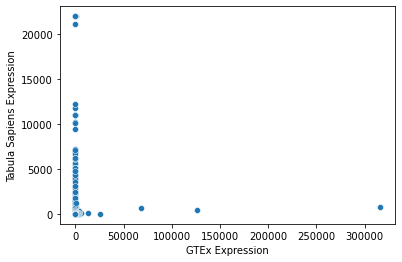

In [133]:
#subset uberonid out of the merged dataframe
uberon_0000178 = uberon_subset('UBERON:0000178', merged_shared_uberon_id_datasets)

#plot the expressions of each gene for GTEx and Tabula Sapiens (maximum median expression)
plot_gtex_tabula(uberon_0000178)

### 3.6.2 UBERON:0000947

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


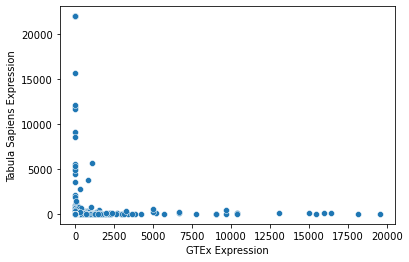

In [135]:
uberon_0000947 = uberon_subset('UBERON:0000947', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0000947)

### 3.6.3 UBERON:0000995

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


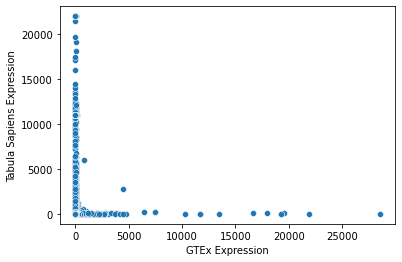

In [136]:
uberon_0000995 = uberon_subset('UBERON:0000995', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0000995)

### 3.6.4 UBERON:0001621

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


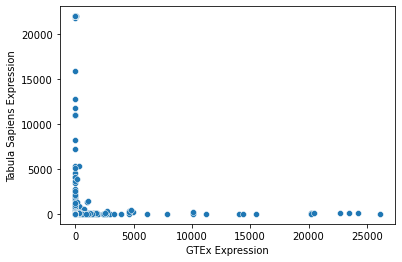

In [134]:
uberon_0001621 = uberon_subset('UBERON:0001621', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0001621)

Since there are multiple cell types for the Tabula Sapiens UBERONID resulting in a higher number of values than GTEx, I will use the maximum of these median values to allow a one-to-one comparison.

### 3.6.5 UBERON:0002048

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


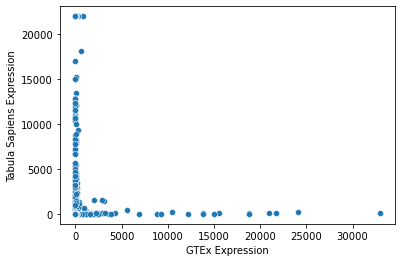

In [137]:
uberon_0002048 = uberon_subset('UBERON:0002048', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002048)

### 3.6.6 UBERON:0002106

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


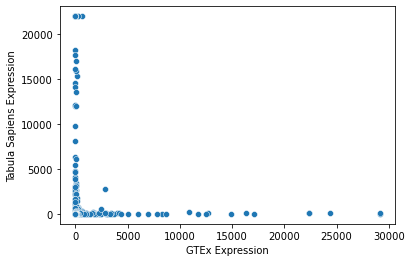

In [138]:
uberon_0002106 = uberon_subset('UBERON:0002106', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002106)

### 3.6.7 UBERON:0002107

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


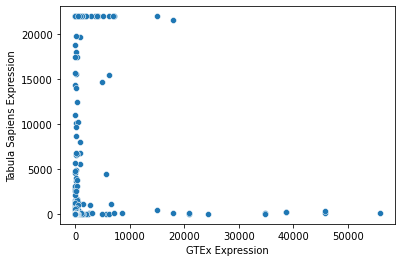

In [139]:
uberon_0002107 = uberon_subset('UBERON:0002107', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002107)

### 3.6.8 UBERON:0002190

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


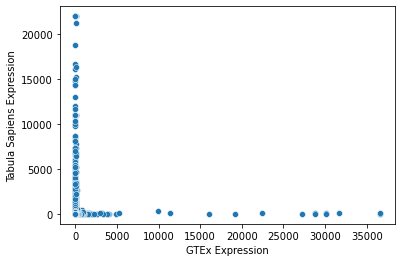

In [140]:
uberon_0002190 = uberon_subset('UBERON:0002190', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002190)

### 3.6.9 UBERON:0002367

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


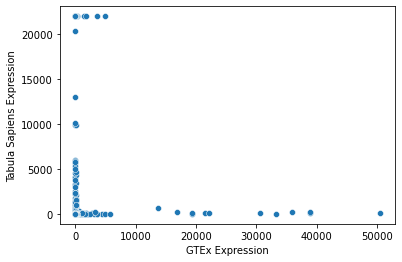

In [141]:
uberon_0002367 = uberon_subset('UBERON:0002367', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002367)

## 3.7 Calculate correlation between Tabula Sapiens and GTEx expression values

In [182]:
#calculate pairwise correlation across genes for each UBERONID
correlations = pd.DataFrame(shared_uberon_id_GTEx_expression.corrwith(ts, axis = 1))
correlations

,0
UBERON:0000178,0.000051
UBERON:0000178,-0.000218
UBERON:0000178,0.000351
UBERON:0000178,0.030397
UBERON:0000178,0.019488
...,...
UBERON:0002367,0.191500
UBERON:0002367,0.045177
UBERON:0002367,0.001263
UBERON:0002367,0.394162


<AxesSubplot:ylabel='Frequency'>

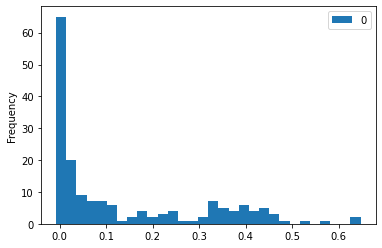

In [185]:
correlations.plot.hist(bins = 30)

Does the order matter for the calculation of correlation across the genes for each UBERONID??????????